---
---

PatchTST model

---
---

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import torch


from google.colab import drive
drive.mount("/content/drive")

!pip install -q \
  transformers \
  datasets \
  evaluate \
  scikit-learn \
  matplotlib \
  seaborn \
  pandas \
  numpy \
  tqdm \
  simplejson \
  loguru


# folder for persistent saving
DRIVE_ROOT = "/content/drive/MyDrive/solar_flare_patchtst"

DATA_DIR     = f"{DRIVE_ROOT}/data"
MODELS_DIR   = f"{DRIVE_ROOT}/models"
LOG_DIR     = f"{DRIVE_ROOT}/logs"
FIGURES_DIR  = f"{DRIVE_ROOT}/figures"
OUTPUT_DIR  = f"{DRIVE_ROOT}/results"

for p in [DATA_DIR, MODELS_DIR, LOG_DIR, FIGURES_DIR, OUTPUT_DIR]:
    os.makedirs(p, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# imports and global settings
import os
import pickle
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset, DatasetDict

from transformers import (
    PatchTSTConfig,
    PatchTSTForClassification,
    TrainingArguments,
    Trainer,
)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE


'cuda'

In [ ]:
import pickle as pkl

# File paths and global constants
RAW_TRAIN_DIR = Path("/content/drive/MyDrive/data/raw/Cleaned SWANSF Dataset/Cleaned SWANSF Dataset/train/")
RAW_TEST_DIR  = Path("/content/drive/MyDrive/data/raw/Cleaned SWANSF Dataset/Cleaned SWANSF Dataset/test/")

PARTITIONS_DIR = Path("/content/drive/MyDrive/data/partitions/")
PARTITIONS_DIR.mkdir(parents=True, exist_ok=True)

NUM_PARTITIONS = 5
NUM_TIMESTEPS  = 60
NUM_FEATURES   = 24

CURRENT_TRAIN_PART = 4
CURRENT_TEST_PART  = 5

FEATURE_NAMES = [
    'R_VALUE', 'TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH', 'SAVNCPP', 'USFLUX',
    'TOTFZ', 'MEANPOT', 'EPSX', 'EPSY', 'EPSZ', 'MEANSHR', 'SHRGT45', 'MEANGAM', 'MEANGBT',
    'MEANGBZ', 'MEANGBH', 'MEANJZH', 'TOTFY', 'MEANJZD', 'MEANALP', 'TOTFX'
]
len(FEATURE_NAMES)


# Function to build NPZ train/test pairs
def build_npz_pairs():
    x_train, y_train = [], []
    x_test,  y_test  = [], []

    for i in range(NUM_PARTITIONS):
        with open(f"{RAW_TRAIN_DIR}/Partition{i+1}_LSBZM-Norm_FPCKNN-impute.pkl", "rb") as f:
            x_train.append(pkl.load(f))
        with open(f"{RAW_TRAIN_DIR}/Partition{i+1}_Labels_LSBZM-Norm_FPCKNN-impute.pkl", "rb") as f:
            y_train.append(pkl.load(f))

        with open(f"{RAW_TEST_DIR}/Partition{i+1}_RUS-Tomek-TimeGAN_LSBZM-Norm_WithoutC_FPCKNN-impute.pkl", "rb") as f:
            x_test.append(pkl.load(f))
        with open(f"{RAW_TEST_DIR}/Partition{i+1}_Labels_RUS-Tomek-TimeGAN_LSBZM-Norm_WithoutC_FPCKNN-impute.pkl", "rb") as f:
            y_test.append(pkl.load(f))

    for i in range(NUM_PARTITIONS):
        for j in range(NUM_PARTITIONS):
            out_path = PARTITIONS_DIR / f"train{i+1}_test{j+1}.npz"
            np.savez(
                out_path,
                x_train=x_train[i],
                y_train=y_train[i],
                x_test=x_test[j],
                y_test=y_test[j],
            )
    print("Saved all 25 train/test NPZ pairs to:", PARTITIONS_DIR)

#build_npz_pairs()


In [ ]:
# Function to load a specific train/test partition pair
def get_partition_pair(train_part: int, test_part: int):
    pair = np.load(PARTITIONS_DIR / f"train{train_part}_test{test_part}.npz")
    Xtr, ytr = pair["x_train"], pair["y_train"]
    Xte, yte = pair["x_test"],  pair["y_test"]
    print(f"Loaded train{train_part}_test{test_part}.npz")
    print("Train:", Xtr.shape, np.bincount(ytr.astype(int)))
    print("Test :", Xte.shape, np.bincount(yte.astype(int)))
    return Xtr, ytr, Xte, yte

Xtr, ytr, Xte, yte = get_partition_pair(CURRENT_TRAIN_PART, CURRENT_TEST_PART)


Loaded train4_test5.npz
Train: (51261, 60, 24) [50096  1165]
Test : (19899, 60, 24) [9999 9900]


In [ ]:
#
def split_train_val(X, y, val_ratio=0.2, random_state=SEED):
    rng = np.random.default_rng(random_state)
    idx = np.arange(len(y))
    rng.shuffle(idx)

    split_idx = int(len(idx) * (1 - val_ratio))
    train_idx, val_idx = idx[:split_idx], idx[split_idx:]

    return X[train_idx], y[train_idx], X[val_idx], y[val_idx]

Xtrain, ytrain, Xval, yval = split_train_val(Xtr, ytr, val_ratio=0.2)

print("Train:", Xtrain.shape, np.bincount(ytrain.astype(int)))
print("Val  :", Xval.shape,   np.bincount(yval.astype(int)))
print("Test :", Xte.shape,    np.bincount(yte.astype(int)))


Train: (41008, 60, 24) [40095   913]
Val  : (10253, 60, 24) [10001   252]
Test : (19899, 60, 24) [9999 9900]


In [ ]:
# Create Hugging Face DatasetDict
dataset_dict = DatasetDict({
    "train": Dataset.from_dict({"past_values": Xtrain.astype(np.float32), "labels": ytrain.astype(np.int64)}),
    "validation": Dataset.from_dict({"past_values": Xval.astype(np.float32), "labels": yval.astype(np.int64)}),
    "test": Dataset.from_dict({"past_values": Xte.astype(np.float32), "labels": yte.astype(np.int64)}),
})
dataset_dict

# collate function for DataLoader
def collate_fn(batch):
    X = torch.tensor([b["past_values"] for b in batch], dtype=torch.float32)

    if "labels" in batch[0]:
        y = torch.tensor([b["labels"] for b in batch], dtype=torch.long)
    elif "label" in batch[0]:
        y = torch.tensor([b["label"] for b in batch], dtype=torch.long)
    else:
        raise KeyError(f"Label key not found in batch keys: {batch[0].keys()}")

    return {
        "past_values": X,
        "labels": y,
    }





In [ ]:
# Function to compute evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, zero_division=0)
    rec = recall_score(labels, preds, zero_division=0)
    f1 = f1_score(labels, preds, zero_division=0)

    cm = confusion_matrix(labels, preds, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    tss = (tp / (tp + fn + 1e-9)) - (fp / (fp + tn + 1e-9))
    hss = (2 * (tp * tn - fp * fn)) / ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn) + 1e-9)

    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "tss": tss, "hss": hss}


In [ ]:
# Compute class weights
cls_count = np.bincount(ytrain.astype(int))
cls_count

# weights inversely proportional to frequency
w0 = 1.0
w1 = float(cls_count[0] / max(cls_count[1], 1))
class_weights = torch.tensor([w0, w1], dtype=torch.float32)
class_weights


tensor([ 1.0000, 43.9157])

---
---

PatchTST config and model

---
---

In [ ]:
patch_length = 6
patch_stride = 3

config = PatchTSTConfig(
    num_input_channels=NUM_FEATURES,
    context_length=NUM_TIMESTEPS,
    num_targets=2,

    patch_length=patch_length,
    patch_stride=patch_stride,

    d_model=128,
    num_hidden_layers=3,
    num_attention_heads=4,
    ffn_dim=512,

    dropout=0.2,
    attention_dropout=0.1,
    ff_dropout=0.2,
    head_dropout=0.1,

    norm_type="layernorm",
    pre_norm=True,

    positional_encoding_type="sincos",
    use_cls_token=True,

    channel_attention=False,
    share_embedding=True,
)

model = PatchTSTForClassification(config).to(DEVICE)


In [ ]:
# Custom Trainer with weighted loss, hugging Face default is model.loss
class WeightedLossTrainer(Trainer):
    def __init__(self, class_weights: torch.Tensor, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    # Override compute_loss to use weighted CrossEntropyLoss
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs["labels"]

        outputs = model(past_values=inputs["past_values"])
        logits = outputs.prediction_logits

        loss_fn = nn.CrossEntropyLoss(
            weight=self.class_weights.to(logits.device)
        )
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

    # Override prediction_step to handle labels correctly
    def prediction_step(
        self,
        model,
        inputs,
        prediction_loss_only=False,
        ignore_keys=None,
    ):
        """
        Override to prevent labels from being passed into PatchTST.forward()
        during evaluation.
        """

        labels = inputs.get("labels")
        inputs = {k: v for k, v in inputs.items() if k != "labels"}

        with torch.no_grad():
            outputs = model(**inputs)

        logits = outputs.prediction_logits

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss(
                weight=self.class_weights.to(logits.device)
            )
            loss = loss_fn(logits, labels)

        if prediction_loss_only:
            return (loss, None, None)

        return (loss, logits, labels)




In [ ]:
# Training setup
#OUTPUT_DIR = "../models/checkpoints/patchtst"
#LOG_DIR    = "../reports/logs/patchtst"
#os.makedirs(OUTPUT_DIR, exist_ok=True)
#os.makedirs(LOG_DIR, exist_ok=True)

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=10,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=128,
    learning_rate=3e-4,
    weight_decay=1e-4,

    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="tss",
    greater_is_better=True,

    logging_dir=LOG_DIR,
    logging_steps=20,

    report_to="none",
    seed=SEED,

    fp16=torch.cuda.is_available(),
    max_grad_norm=1.0,

    remove_unused_columns=False
)

trainer = WeightedLossTrainer(
    class_weights=class_weights,
    model=model,
    args=training_args,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["validation"],
    data_collator=collate_fn,
    compute_metrics=compute_metrics,

)

trainer.train()



Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
RESULTS_DIR = "../reports/figures/patchtst"
os.makedirs(RESULTS_DIR, exist_ok=True)

def evaluate_split(trainer, dataset, split_name):
    preds = trainer.predict(dataset)
    y_true = preds.label_ids
    y_pred = np.argmax(preds.predictions, axis=1)

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    tss = (tp / (tp + fn + 1e-9)) - (fp / (fp + tn + 1e-9))

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["True 0", "True 1"])
    plt.title(f"Confusion Matrix: {split_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()

    out_path = os.path.join(
        RESULTS_DIR,
        f"confmat_{split_name}_train{CURRENT_TRAIN_PART}_test{CURRENT_TEST_PART}_p{patch_length}_s{patch_stride}.png"
    )
    plt.savefig(out_path, dpi=300)
    plt.close()

    metrics = compute_metrics((preds.predictions, y_true))
    metrics["split"] = split_name
    metrics["tss_from_cm"] = tss
    return metrics, out_path

val_metrics, val_cm_path = evaluate_split(trainer, dataset_dict["validation"], "validation")
test_metrics, test_cm_path = evaluate_split(trainer, dataset_dict["test"], "test")

val_metrics, val_cm_path, test_metrics, test_cm_path


({'accuracy': 0.9133954690795292,
  'precision': 0.14675052410901468,
  'recall': 0.8015267175572519,
  'f1': 0.24808033077377437,
  'tss': np.float64(0.7169523600006902),
  'hss': np.float64(0.2247196802494311),
  'split': 'validation',
  'tss_from_cm': np.float64(0.7169523600006902)},
 '../reports/figures/patchtst/confmat_validation_train4_test5_p6_s3.png',
 {'accuracy': 0.7492675651201193,
  'precision': 0.9770330442934145,
  'recall': 0.474937343358396,
  'f1': 0.6391720965887313,
  'tss': np.float64(0.46513244090711725),
  'hss': np.float64(0.4801547346688082),
  'split': 'test',
  'tss_from_cm': np.float64(0.46513244090711725)},
 '../reports/figures/patchtst/confmat_test_train4_test5_p6_s3.png')

---
---

comparison and experiment log

---
---

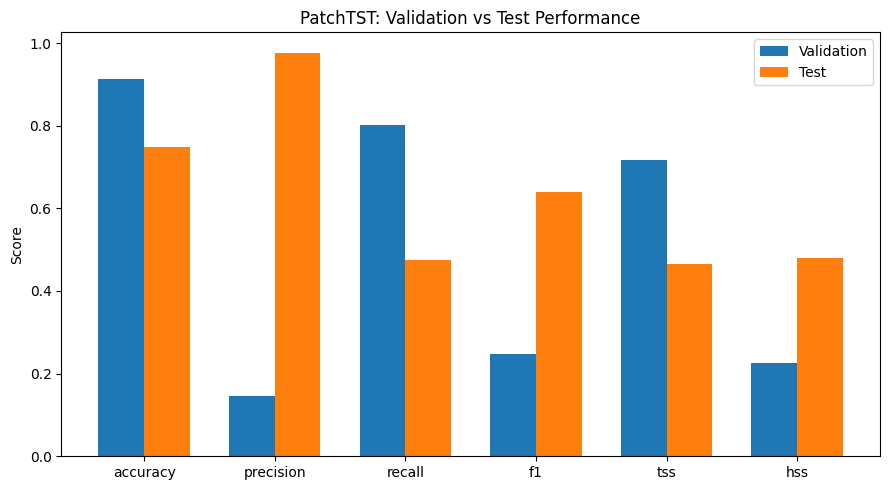

,train_part,test_part,patch_length,patch_stride,val_accuracy,val_precision,val_recall,val_f1,val_tss,val_hss,test_accuracy,test_precision,test_recall,test_f1,test_tss,test_hss
0,4,5,6,3,0.913395,0.146751,0.801527,0.24808,0.716952,0.22472,0.749268,0.977033,0.474937,0.639172,0.465132,0.480155


In [ ]:
# Comparison DataFrame
comparison_df = pd.DataFrame([val_metrics, test_metrics]).set_index("split")
comparison_df

# Bar plot comparison
metrics_to_plot = ["accuracy", "precision", "recall", "f1", "tss", "hss"]

plt.figure(figsize=(9, 5))
x = np.arange(len(metrics_to_plot))
width = 0.35

plt.bar(x - width/2, comparison_df.loc["validation", metrics_to_plot], width, label="Validation")
plt.bar(x + width/2, comparison_df.loc["test", metrics_to_plot], width, label="Test")

plt.xticks(x, metrics_to_plot)
plt.ylabel("Score")
plt.title("PatchTST: Validation vs Test Performance")
plt.legend()
plt.tight_layout()

bar_path = os.path.join(
    RESULTS_DIR,
    f"val_vs_test_train{CURRENT_TRAIN_PART}_test{CURRENT_TEST_PART}_p{patch_length}_s{patch_stride}.png"
)
plt.savefig(bar_path, dpi=200)
plt.show()

bar_path

# Save experiment summary
SUMMARY_DIR = "../reports/patchtst"
os.makedirs(SUMMARY_DIR, exist_ok=True)

summary_path = os.path.join(SUMMARY_DIR, "experiment_summary.csv")

row = {
    "train_part": CURRENT_TRAIN_PART,
    "test_part": CURRENT_TEST_PART,
    "patch_length": patch_length,
    "patch_stride": patch_stride,
    "val_accuracy": float(comparison_df.loc["validation", "accuracy"]),
    "val_precision": float(comparison_df.loc["validation", "precision"]),
    "val_recall": float(comparison_df.loc["validation", "recall"]),
    "val_f1": float(comparison_df.loc["validation", "f1"]),
    "val_tss": float(comparison_df.loc["validation", "tss"]),
    "val_hss": float(comparison_df.loc["validation", "hss"]),
    "test_accuracy": float(comparison_df.loc["test", "accuracy"]),
    "test_precision": float(comparison_df.loc["test", "precision"]),
    "test_recall": float(comparison_df.loc["test", "recall"]),
    "test_f1": float(comparison_df.loc["test", "f1"]),
    "test_tss": float(comparison_df.loc["test", "tss"]),
    "test_hss": float(comparison_df.loc["test", "hss"]),
}

if os.path.exists(summary_path):
    df = pd.read_csv(summary_path)
    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
else:
    df = pd.DataFrame([row])

df.to_csv(summary_path, index=False)
df.tail(10)




---
---

## Experiment Loop
run this one for all partitions

---
---

In [ ]:
assert PARTITIONS_DIR.exists()
assert len(list(PARTITIONS_DIR.glob("train*_test*.npz"))) == 25
assert os.path.isdir(DRIVE_ROOT)
assert torch.cuda.is_available()


In [ ]:
PATCH_GRID = [
    (6, 3),
    (8, 4),
    (10, 5),
]


In [ ]:
SUMMARY_PATH = f"{DRIVE_ROOT}/results/patchtst/experiment_summary.csv"
os.makedirs(os.path.dirname(SUMMARY_PATH), exist_ok=True)

# Load existing summary if present
if os.path.exists(SUMMARY_PATH):
    summary_df = pd.read_csv(SUMMARY_PATH)
else:
    summary_df = pd.DataFrame()

def already_ran(train_part, test_part, patch_length, patch_stride):
    if summary_df.empty:
        return False
    mask = (
        (summary_df.train_part == train_part) &
        (summary_df.test_part == test_part) &
        (summary_df.patch_length == patch_length) &
        (summary_df.patch_stride == patch_stride)
    )
    return mask.any()


for patch_length, patch_stride in PATCH_GRID:
    print(f"\n=== Patch length {patch_length}, stride {patch_stride} ===")

    for train_part in range(1, NUM_PARTITIONS + 1):
        for test_part in range(1, NUM_PARTITIONS + 1):

            if already_ran(train_part, test_part, patch_length, patch_stride):
                print(f"Skipping train{train_part}_test{test_part} (already done)")
                continue

            print("\n" + "=" * 40)
            print(f" Train P{train_part} → Test P{test_part}")
            print("=" * 40)

            # --------------------------------------------------
            # Load partition pair
            # --------------------------------------------------
            Xtr, ytr, Xte, yte = get_partition_pair(train_part, test_part)
            Xtrain, ytrain, Xval, yval = split_train_val(Xtr, ytr, val_ratio=0.2)

            dataset_dict = DatasetDict({
                "train": Dataset.from_dict({
                    "past_values": Xtrain.astype(np.float32),
                    "labels": ytrain.astype(np.int64),
                }),
                "validation": Dataset.from_dict({
                    "past_values": Xval.astype(np.float32),
                    "labels": yval.astype(np.int64),
                }),
                "test": Dataset.from_dict({
                    "past_values": Xte.astype(np.float32),
                    "labels": yte.astype(np.int64),
                }),
            })

            # --------------------------------------------------
            # Class weights
            # --------------------------------------------------
            cls_count = np.bincount(ytrain.astype(int))
            w1 = float(cls_count[0] / max(cls_count[1], 1))
            class_weights = torch.tensor([1.0, w1], dtype=torch.float32)

            # --------------------------------------------------
            # Model
            # --------------------------------------------------
            config = PatchTSTConfig(
                num_input_channels=NUM_FEATURES,
                context_length=NUM_TIMESTEPS,
                num_targets=2,
                patch_length=patch_length,
                patch_stride=patch_stride,
                d_model=128,
                num_hidden_layers=3,
                num_attention_heads=4,
                ffn_dim=512,
                dropout=0.2,
                attention_dropout=0.1,
                ff_dropout=0.2,
                head_dropout=0.1,
                norm_type="layernorm",
                pre_norm=True,
                positional_encoding_type="sincos",
                use_cls_token=True,
                channel_attention=False,
                share_embedding=True,
            )

            model = PatchTSTForClassification(config).to(DEVICE)

            # --------------------------------------------------
            # Per-run directories
            # --------------------------------------------------
            run_name = f"train{train_part}_test{test_part}_p{patch_length}_s{patch_stride}"
            run_output_dir = f"{MODELS_DIR}/{run_name}"
            run_log_dir = f"{LOG_DIR}/{run_name}"
            run_fig_dir = f"{FIGURES_DIR}/{run_name}"

            os.makedirs(run_output_dir, exist_ok=True)
            os.makedirs(run_log_dir, exist_ok=True)
            os.makedirs(run_fig_dir, exist_ok=True)

            training_args = TrainingArguments(
                output_dir=run_output_dir,
                logging_dir=run_log_dir,
                num_train_epochs=10,
                per_device_train_batch_size=64,
                per_device_eval_batch_size=128,
                learning_rate=3e-4,
                weight_decay=1e-4,
                eval_strategy="epoch",
                save_strategy="epoch",
                save_total_limit=2,
                load_best_model_at_end=True,
                metric_for_best_model="tss",
                greater_is_better=True,
                report_to="none",
                seed=SEED,
                fp16=torch.cuda.is_available(),
                max_grad_norm=1.0,
                remove_unused_columns=False,
            )

            trainer = WeightedLossTrainer(
                class_weights=class_weights,
                model=model,
                args=training_args,
                train_dataset=dataset_dict["train"],
                eval_dataset=dataset_dict["validation"],
                data_collator=collate_fn,
                compute_metrics=compute_metrics,
            )

            # --------------------------------------------------
            # Resume if checkpoint exists
            # --------------------------------------------------
            last_ckpt = None
            ckpts = [d for d in os.listdir(run_output_dir) if d.startswith("checkpoint-")]
            if ckpts:
                last_ckpt = os.path.join(run_output_dir, sorted(ckpts)[-1])
                print("Resuming from:", last_ckpt)

            trainer.train(resume_from_checkpoint=last_ckpt)

            # --------------------------------------------------
            # Evaluation
            # --------------------------------------------------
            val_metrics, _ = evaluate_split(trainer, dataset_dict["validation"], "validation")
            test_metrics, _ = evaluate_split(trainer, dataset_dict["test"], "test")

            row = {
                "train_part": train_part,
                "test_part": test_part,
                "patch_length": patch_length,
                "patch_stride": patch_stride,
                **{f"val_{k}": v for k, v in val_metrics.items() if k != "split"},
                **{f"test_{k}": v for k, v in test_metrics.items() if k != "split"},
            }

            summary_df = pd.concat([summary_df, pd.DataFrame([row])], ignore_index=True)
            summary_df.to_csv(SUMMARY_PATH, index=False)

            print("Saved results →", SUMMARY_PATH)



=== Patch length 6, stride 3 ===

 Train P1 → Test P1
Loaded train1_test1.npz
Train: (73492, 60, 24) [72238  1254]
Test : (18773, 60, 24) [9995 8778]
Resuming from: /content/drive/MyDrive/solar_flare_patchtst/models/train1_test1_p6_s3/checkpoint-9190


Epoch,Training Loss,Validation Loss


Saved results → /content/drive/MyDrive/solar_flare_patchtst/results/patchtst/experiment_summary.csv

 Train P1 → Test P2
Loaded train1_test2.npz
Train: (73492, 60, 24) [72238  1254]
Test : (19807, 60, 24) [10000  9807]


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Tss,Hss
1,0.517300,0.317513,0.911286,0.143151,0.797710,0.242741,0.711058,0.219140
2,0.414500,0.427148,0.960201,0.256410,0.648855,0.367568,0.614707,0.350984
3,0.428100,0.342144,0.951425,0.221675,0.687023,0.335196,0.643246,0.316781
4,0.414400,0.487669,0.975509,0.372396,0.545802,0.442724,0.529108,0.430660
5,0.375000,0.380332,0.958296,0.252468,0.683206,0.368692,0.646495,0.351820
6,0.352400,0.462005,0.975168,0.379953,0.622137,0.471780,0.603713,0.459825
7,0.336600,0.513454,0.978570,0.427397,0.595420,0.497608,0.580943,0.486961
8,0.348300,0.456143,0.975849,0.382278,0.576336,0.459665,0.559435,0.447831
9,0.324000,0.427186,0.975509,0.389140,0.656489,0.488636,0.637787,0.476929
10,0.295000,0.432970,0.976393,0.399050,0.641221,0.491947,0.623697,0.480533


Saved results → /content/drive/MyDrive/solar_flare_patchtst/results/patchtst/experiment_summary.csv

 Train P1 → Test P3
Loaded train1_test3.npz
Train: (73492, 60, 24) [72238  1254]
Test : (19965, 60, 24) [9997 9968]


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Tss,Hss
1,0.554100,0.267565,0.877066,0.117005,0.900763,0.207108,0.777400,0.181277
2,0.396500,0.401369,0.955643,0.232143,0.645038,0.341414,0.606318,0.323685
3,0.433800,0.314103,0.934281,0.178832,0.748092,0.288660,0.685752,0.267588
4,0.420100,0.511184,0.974692,0.355263,0.515267,0.420561,0.498297,0.408071
5,0.404600,0.372463,0.955643,0.241379,0.694656,0.358268,0.655036,0.340829
6,0.360200,0.500366,0.968297,0.308271,0.625954,0.413098,0.600464,0.398737
7,0.356100,0.533004,0.974080,0.353086,0.545802,0.428786,0.527654,0.416148
8,0.340100,0.470531,0.971835,0.326484,0.545802,0.408571,0.525368,0.395078
9,0.327700,0.432082,0.969590,0.324478,0.652672,0.433460,0.628013,0.419641
10,0.331800,0.449473,0.972447,0.344902,0.606870,0.439834,0.585952,0.426805


Saved results → /content/drive/MyDrive/solar_flare_patchtst/results/patchtst/experiment_summary.csv

 Train P1 → Test P4
Loaded train1_test4.npz
Train: (73492, 60, 24) [72238  1254]
Test : (19320, 60, 24) [10000  9320]


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Tss,Hss
1,0.554100,0.267565,0.877066,0.117005,0.900763,0.207108,0.777400,0.181277
2,0.396500,0.401369,0.955643,0.232143,0.645038,0.341414,0.606318,0.323685
3,0.433800,0.314103,0.934281,0.178832,0.748092,0.288660,0.685752,0.267588
4,0.420100,0.511184,0.974692,0.355263,0.515267,0.420561,0.498297,0.408071
5,0.404600,0.372463,0.955643,0.241379,0.694656,0.358268,0.655036,0.340829
6,0.360200,0.500366,0.968297,0.308271,0.625954,0.413098,0.600464,0.398737
7,0.356100,0.533004,0.974080,0.353086,0.545802,0.428786,0.527654,0.416148
8,0.340100,0.470531,0.971835,0.326484,0.545802,0.408571,0.525368,0.395078
9,0.327700,0.432082,0.969590,0.324478,0.652672,0.433460,0.628013,0.419641
10,0.331800,0.449473,0.972447,0.344902,0.606870,0.439834,0.585952,0.426805


Saved results → /content/drive/MyDrive/solar_flare_patchtst/results/patchtst/experiment_summary.csv

 Train P1 → Test P5
Loaded train1_test5.npz
Train: (73492, 60, 24) [72238  1254]
Test : (19899, 60, 24) [9999 9900]


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Tss,Hss
1,0.554100,0.267565,0.877066,0.117005,0.900763,0.207108,0.777400,0.181277
2,0.396500,0.401369,0.955643,0.232143,0.645038,0.341414,0.606318,0.323685
3,0.433800,0.314103,0.934281,0.178832,0.748092,0.288660,0.685752,0.267588
4,0.420100,0.511184,0.974692,0.355263,0.515267,0.420561,0.498297,0.408071
5,0.404600,0.372463,0.955643,0.241379,0.694656,0.358268,0.655036,0.340829
6,0.360200,0.500366,0.968297,0.308271,0.625954,0.413098,0.600464,0.398737
7,0.356100,0.533004,0.974080,0.353086,0.545802,0.428786,0.527654,0.416148
8,0.340100,0.470531,0.971835,0.326484,0.545802,0.408571,0.525368,0.395078
9,0.327700,0.432082,0.969590,0.324478,0.652672,0.433460,0.628013,0.419641
10,0.331800,0.449473,0.972447,0.344902,0.606870,0.439834,0.585952,0.426805


Saved results → /content/drive/MyDrive/solar_flare_patchtst/results/patchtst/experiment_summary.csv

 Train P2 → Test P1
Loaded train2_test1.npz
Train: (88557, 60, 24) [87156  1401]
Test : (18773, 60, 24) [9995 8778]


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Tss,Hss
1,0.463000,0.338213,0.938855,0.177276,0.780142,0.288903,0.721565,0.269961
2,0.456800,0.265811,0.922200,0.153603,0.861702,0.260730,0.784881,0.240196
3,0.432200,0.316758,0.953704,0.224385,0.776596,0.348172,0.733165,0.331661
4,0.442600,0.729420,0.975215,0.321995,0.503546,0.392808,0.486392,0.380781
5,0.377600,0.426798,0.967931,0.277259,0.631206,0.385281,0.604585,0.371373
6,0.383300,0.527621,0.976908,0.354691,0.549645,0.431154,0.533466,0.419928
7,0.378700,0.512993,0.975553,0.339703,0.567376,0.424967,0.549533,0.413281
8,0.342600,0.407070,0.968835,0.295455,0.691489,0.414013,0.664811,0.400641
9,0.325300,0.440708,0.971093,0.312704,0.680851,0.428571,0.656640,0.415824
10,0.341300,0.473136,0.973521,0.330922,0.648936,0.438323,0.627708,0.426223


Saved results → /content/drive/MyDrive/solar_flare_patchtst/results/patchtst/experiment_summary.csv

 Train P2 → Test P2
Loaded train2_test2.npz
Train: (88557, 60, 24) [87156  1401]
Test : (19807, 60, 24) [10000  9807]


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Tss,Hss
1,0.463000,0.338213,0.938855,0.177276,0.780142,0.288903,0.721565,0.269961
2,0.456800,0.265811,0.922200,0.153603,0.861702,0.260730,0.784881,0.240196
3,0.432200,0.316758,0.953704,0.224385,0.776596,0.348172,0.733165,0.331661
4,0.442600,0.729420,0.975215,0.321995,0.503546,0.392808,0.486392,0.380781
5,0.377600,0.426798,0.967931,0.277259,0.631206,0.385281,0.604585,0.371373
6,0.383300,0.527621,0.976908,0.354691,0.549645,0.431154,0.533466,0.419928
7,0.378700,0.512993,0.975553,0.339703,0.567376,0.424967,0.549533,0.413281
8,0.342600,0.407070,0.968835,0.295455,0.691489,0.414013,0.664811,0.400641
9,0.325300,0.440708,0.971093,0.312704,0.680851,0.428571,0.656640,0.415824
10,0.341300,0.473136,0.973521,0.330922,0.648936,0.438323,0.627708,0.426223


Saved results → /content/drive/MyDrive/solar_flare_patchtst/results/patchtst/experiment_summary.csv

 Train P2 → Test P3
Loaded train2_test3.npz
Train: (88557, 60, 24) [87156  1401]
Test : (19965, 60, 24) [9997 9968]


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Tss,Hss
1,0.463000,0.338213,0.938855,0.177276,0.780142,0.288903,0.721565,0.269961
2,0.456800,0.265811,0.922200,0.153603,0.861702,0.260730,0.784881,0.240196
3,0.432200,0.316758,0.953704,0.224385,0.776596,0.348172,0.733165,0.331661
4,0.442600,0.729420,0.975215,0.321995,0.503546,0.392808,0.486392,0.380781
5,0.377600,0.426798,0.967931,0.277259,0.631206,0.385281,0.604585,0.371373
6,0.383300,0.527621,0.976908,0.354691,0.549645,0.431154,0.533466,0.419928
7,0.378700,0.512993,0.975553,0.339703,0.567376,0.424967,0.549533,0.413281
8,0.342600,0.407070,0.968835,0.295455,0.691489,0.414013,0.664811,0.400641
9,0.325300,0.440708,0.971093,0.312704,0.680851,0.428571,0.656640,0.415824
10,0.341300,0.473136,0.973521,0.330922,0.648936,0.438323,0.627708,0.426223


Saved results → /content/drive/MyDrive/solar_flare_patchtst/results/patchtst/experiment_summary.csv

 Train P2 → Test P4
Loaded train2_test4.npz
Train: (88557, 60, 24) [87156  1401]
Test : (19320, 60, 24) [10000  9320]


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Tss,Hss
1,0.463000,0.338213,0.938855,0.177276,0.780142,0.288903,0.721565,0.269961
2,0.456800,0.265811,0.922200,0.153603,0.861702,0.260730,0.784881,0.240196
3,0.432200,0.316758,0.953704,0.224385,0.776596,0.348172,0.733165,0.331661
4,0.442600,0.729420,0.975215,0.321995,0.503546,0.392808,0.486392,0.380781
5,0.377600,0.426798,0.967931,0.277259,0.631206,0.385281,0.604585,0.371373
6,0.383300,0.527621,0.976908,0.354691,0.549645,0.431154,0.533466,0.419928
7,0.378700,0.512993,0.975553,0.339703,0.567376,0.424967,0.549533,0.413281
8,0.342600,0.407070,0.968835,0.295455,0.691489,0.414013,0.664811,0.400641
9,0.325300,0.440708,0.971093,0.312704,0.680851,0.428571,0.656640,0.415824
10,0.341300,0.473136,0.973521,0.330922,0.648936,0.438323,0.627708,0.426223


Saved results → /content/drive/MyDrive/solar_flare_patchtst/results/patchtst/experiment_summary.csv

 Train P2 → Test P5
Loaded train2_test5.npz
Train: (88557, 60, 24) [87156  1401]
Test : (19899, 60, 24) [9999 9900]


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Tss,Hss
1,0.463000,0.338213,0.938855,0.177276,0.780142,0.288903,0.721565,0.269961
2,0.456800,0.265811,0.922200,0.153603,0.861702,0.260730,0.784881,0.240196
3,0.432200,0.316758,0.953704,0.224385,0.776596,0.348172,0.733165,0.331661
4,0.442600,0.729420,0.975215,0.321995,0.503546,0.392808,0.486392,0.380781
5,0.377600,0.426798,0.967931,0.277259,0.631206,0.385281,0.604585,0.371373
6,0.383300,0.527621,0.976908,0.354691,0.549645,0.431154,0.533466,0.419928
7,0.378700,0.512993,0.975553,0.339703,0.567376,0.424967,0.549533,0.413281
8,0.342600,0.407070,0.968835,0.295455,0.691489,0.414013,0.664811,0.400641
9,0.325300,0.440708,0.971093,0.312704,0.680851,0.428571,0.656640,0.415824
10,0.341300,0.473136,0.973521,0.330922,0.648936,0.438323,0.627708,0.426223


Saved results → /content/drive/MyDrive/solar_flare_patchtst/results/patchtst/experiment_summary.csv

 Train P3 → Test P1
Loaded train3_test1.npz
Train: (42510, 60, 24) [41086  1424]
Test : (18773, 60, 24) [9995 8778]


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Tss,Hss
1,0.386900,0.337257,0.925665,0.258575,0.736842,0.382812,0.668605,0.352836
2,0.334200,0.285707,0.829922,0.150059,0.951128,0.259221,0.777136,0.216897
3,0.321100,0.278638,0.883674,0.196982,0.883459,0.322138,0.767140,0.285585
4,0.299700,0.299872,0.923547,0.256962,0.763158,0.384470,0.691885,0.354241
5,0.279600,0.290115,0.921430,0.257831,0.804511,0.390511,0.729718,0.360192
6,0.287000,0.422565,0.949541,0.344168,0.676692,0.456274,0.635045,0.432745
7,0.275700,0.317485,0.935074,0.291545,0.751880,0.420168,0.692870,0.392789
8,0.257500,0.271094,0.920607,0.255675,0.804511,0.388033,0.728868,0.357526
9,0.260700,0.268020,0.926841,0.275819,0.823308,0.413208,0.753493,0.384351
10,0.244500,0.270146,0.932369,0.291498,0.812030,0.428997,0.748286,0.401436


Saved results → /content/drive/MyDrive/solar_flare_patchtst/results/patchtst/experiment_summary.csv

 Train P3 → Test P2
Loaded train3_test2.npz
Train: (42510, 60, 24) [41086  1424]
Test : (19807, 60, 24) [10000  9807]


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Tss,Hss
1,0.386900,0.337257,0.925665,0.258575,0.736842,0.382812,0.668605,0.352836
2,0.334200,0.285707,0.829922,0.150059,0.951128,0.259221,0.777136,0.216897
3,0.321100,0.278638,0.883674,0.196982,0.883459,0.322138,0.767140,0.285585
4,0.299700,0.299872,0.923547,0.256962,0.763158,0.384470,0.691885,0.354241
5,0.279600,0.290115,0.921430,0.257831,0.804511,0.390511,0.729718,0.360192
6,0.287000,0.422565,0.949541,0.344168,0.676692,0.456274,0.635045,0.432745
7,0.275700,0.317485,0.935074,0.291545,0.751880,0.420168,0.692870,0.392789
8,0.257500,0.271094,0.920607,0.255675,0.804511,0.388033,0.728868,0.357526
9,0.260700,0.268020,0.926841,0.275819,0.823308,0.413208,0.753493,0.384351
10,0.244500,0.270146,0.932369,0.291498,0.812030,0.428997,0.748286,0.401436


Saved results → /content/drive/MyDrive/solar_flare_patchtst/results/patchtst/experiment_summary.csv

 Train P3 → Test P3
Loaded train3_test3.npz
Train: (42510, 60, 24) [41086  1424]
Test : (19965, 60, 24) [9997 9968]


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Tss,Hss
1,0.386900,0.337257,0.925665,0.258575,0.736842,0.382812,0.668605,0.352836
2,0.334200,0.285707,0.829922,0.150059,0.951128,0.259221,0.777136,0.216897
3,0.321100,0.278638,0.883674,0.196982,0.883459,0.322138,0.767140,0.285585
4,0.299700,0.299872,0.923547,0.256962,0.763158,0.384470,0.691885,0.354241
5,0.279600,0.290115,0.921430,0.257831,0.804511,0.390511,0.729718,0.360192
6,0.287000,0.422565,0.949541,0.344168,0.676692,0.456274,0.635045,0.432745
7,0.275700,0.317485,0.935074,0.291545,0.751880,0.420168,0.692870,0.392789
8,0.257500,0.271094,0.920607,0.255675,0.804511,0.388033,0.728868,0.357526
9,0.260700,0.268020,0.926841,0.275819,0.823308,0.413208,0.753493,0.384351
10,0.244500,0.270146,0.932369,0.291498,0.812030,0.428997,0.748286,0.401436


Saved results → /content/drive/MyDrive/solar_flare_patchtst/results/patchtst/experiment_summary.csv

 Train P3 → Test P4
Loaded train3_test4.npz
Train: (42510, 60, 24) [41086  1424]
Test : (19320, 60, 24) [10000  9320]


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Tss,Hss
1,0.386900,0.337257,0.925665,0.258575,0.736842,0.382812,0.668605,0.352836
2,0.334200,0.285707,0.829922,0.150059,0.951128,0.259221,0.777136,0.216897
3,0.321100,0.278638,0.883674,0.196982,0.883459,0.322138,0.767140,0.285585
4,0.299700,0.299872,0.923547,0.256962,0.763158,0.384470,0.691885,0.354241
5,0.279600,0.290115,0.921430,0.257831,0.804511,0.390511,0.729718,0.360192
6,0.287000,0.422565,0.949541,0.344168,0.676692,0.456274,0.635045,0.432745
7,0.275700,0.317485,0.935074,0.291545,0.751880,0.420168,0.692870,0.392789
8,0.257500,0.271094,0.920607,0.255675,0.804511,0.388033,0.728868,0.357526
9,0.260700,0.268020,0.926841,0.275819,0.823308,0.413208,0.753493,0.384351
10,0.244500,0.270146,0.932369,0.291498,0.812030,0.428997,0.748286,0.401436


Saved results → /content/drive/MyDrive/solar_flare_patchtst/results/patchtst/experiment_summary.csv

 Train P3 → Test P5
Loaded train3_test5.npz
Train: (42510, 60, 24) [41086  1424]
Test : (19899, 60, 24) [9999 9900]


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Tss,Hss
1,0.386900,0.337257,0.925665,0.258575,0.736842,0.382812,0.668605,0.352836
2,0.334200,0.285707,0.829922,0.150059,0.951128,0.259221,0.777136,0.216897
3,0.321100,0.278638,0.883674,0.196982,0.883459,0.322138,0.767140,0.285585
4,0.299700,0.299872,0.923547,0.256962,0.763158,0.384470,0.691885,0.354241
5,0.279600,0.290115,0.921430,0.257831,0.804511,0.390511,0.729718,0.360192
6,0.287000,0.422565,0.949541,0.344168,0.676692,0.456274,0.635045,0.432745
7,0.275700,0.317485,0.935074,0.291545,0.751880,0.420168,0.692870,0.392789
8,0.257500,0.271094,0.920607,0.255675,0.804511,0.388033,0.728868,0.357526
9,0.260700,0.268020,0.926841,0.275819,0.823308,0.413208,0.753493,0.384351
10,0.244500,0.270146,0.932369,0.291498,0.812030,0.428997,0.748286,0.401436


Saved results → /content/drive/MyDrive/solar_flare_patchtst/results/patchtst/experiment_summary.csv

 Train P4 → Test P1
Loaded train4_test1.npz
Train: (51261, 60, 24) [50096  1165]
Test : (18773, 60, 24) [9995 8778]


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Tss,Hss
1,0.382200,0.925966,0.977665,0.564246,0.400794,0.468677,0.392994,0.457604
2,0.343600,0.365504,0.955623,0.332231,0.797619,0.469078,0.757223,0.449992
3,0.301400,0.633982,0.977275,0.535581,0.567460,0.551060,0.555062,0.539412
4,0.304000,0.743554,0.979226,0.588235,0.515873,0.549683,0.506774,0.539097
5,0.313800,0.372596,0.962060,0.374771,0.813492,0.513141,0.779295,0.496187
6,0.254700,0.382432,0.970350,0.441704,0.781746,0.564470,0.756849,0.550347
7,0.275600,0.378475,0.967912,0.415755,0.753968,0.535966,0.727271,0.520782
8,0.240300,0.269860,0.967522,0.419483,0.837302,0.558940,0.808105,0.544007
9,0.231300,0.288630,0.973179,0.473441,0.813492,0.598540,0.790694,0.585666
10,0.200200,0.294660,0.972788,0.468677,0.801587,0.591508,0.778690,0.578431


Saved results → /content/drive/MyDrive/solar_flare_patchtst/results/patchtst/experiment_summary.csv

 Train P4 → Test P2
Loaded train4_test2.npz
Train: (51261, 60, 24) [50096  1165]
Test : (19807, 60, 24) [10000  9807]


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Tss,Hss
1,0.382200,0.925966,0.977665,0.564246,0.400794,0.468677,0.392994,0.457604
2,0.343600,0.365504,0.955623,0.332231,0.797619,0.469078,0.757223,0.449992
3,0.301400,0.633982,0.977275,0.535581,0.567460,0.551060,0.555062,0.539412
4,0.304000,0.743554,0.979226,0.588235,0.515873,0.549683,0.506774,0.539097
5,0.313800,0.372596,0.962060,0.374771,0.813492,0.513141,0.779295,0.496187
6,0.254700,0.382432,0.970350,0.441704,0.781746,0.564470,0.756849,0.550347
7,0.275600,0.378475,0.967912,0.415755,0.753968,0.535966,0.727271,0.520782
8,0.240300,0.269860,0.967522,0.419483,0.837302,0.558940,0.808105,0.544007
9,0.231300,0.288630,0.973179,0.473441,0.813492,0.598540,0.790694,0.585666
10,0.200200,0.294660,0.972788,0.468677,0.801587,0.591508,0.778690,0.578431


Saved results → /content/drive/MyDrive/solar_flare_patchtst/results/patchtst/experiment_summary.csv

 Train P4 → Test P3
Loaded train4_test3.npz
Train: (51261, 60, 24) [50096  1165]
Test : (19965, 60, 24) [9997 9968]


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Tss,Hss
1,0.382200,0.925966,0.977665,0.564246,0.400794,0.468677,0.392994,0.457604
2,0.343600,0.365504,0.955623,0.332231,0.797619,0.469078,0.757223,0.449992
3,0.301400,0.633982,0.977275,0.535581,0.567460,0.551060,0.555062,0.539412
4,0.304000,0.743554,0.979226,0.588235,0.515873,0.549683,0.506774,0.539097
5,0.313800,0.372596,0.962060,0.374771,0.813492,0.513141,0.779295,0.496187
6,0.254700,0.382432,0.970350,0.441704,0.781746,0.564470,0.756849,0.550347
7,0.275600,0.378475,0.967912,0.415755,0.753968,0.535966,0.727271,0.520782
8,0.240300,0.269860,0.967522,0.419483,0.837302,0.558940,0.808105,0.544007
9,0.231300,0.288630,0.973179,0.473441,0.813492,0.598540,0.790694,0.585666
10,0.200200,0.294660,0.972788,0.468677,0.801587,0.591508,0.778690,0.578431


Saved results → /content/drive/MyDrive/solar_flare_patchtst/results/patchtst/experiment_summary.csv

 Train P4 → Test P4
Loaded train4_test4.npz
Train: (51261, 60, 24) [50096  1165]
Test : (19320, 60, 24) [10000  9320]


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Tss,Hss
1,0.382200,0.925966,0.977665,0.564246,0.400794,0.468677,0.392994,0.457604
2,0.343600,0.365504,0.955623,0.332231,0.797619,0.469078,0.757223,0.449992
3,0.301400,0.633982,0.977275,0.535581,0.567460,0.551060,0.555062,0.539412
4,0.304000,0.743554,0.979226,0.588235,0.515873,0.549683,0.506774,0.539097
5,0.313800,0.372596,0.962060,0.374771,0.813492,0.513141,0.779295,0.496187
6,0.254700,0.382432,0.970350,0.441704,0.781746,0.564470,0.756849,0.550347
7,0.275600,0.378475,0.967912,0.415755,0.753968,0.535966,0.727271,0.520782
8,0.240300,0.269860,0.967522,0.419483,0.837302,0.558940,0.808105,0.544007
9,0.231300,0.288630,0.973179,0.473441,0.813492,0.598540,0.790694,0.585666
10,0.200200,0.294660,0.972788,0.468677,0.801587,0.591508,0.778690,0.578431


Saved results → /content/drive/MyDrive/solar_flare_patchtst/results/patchtst/experiment_summary.csv

 Train P4 → Test P5
Loaded train4_test5.npz
Train: (51261, 60, 24) [50096  1165]
Test : (19899, 60, 24) [9999 9900]


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Tss,Hss
1,0.382200,0.925966,0.977665,0.564246,0.400794,0.468677,0.392994,0.457604
2,0.343600,0.365504,0.955623,0.332231,0.797619,0.469078,0.757223,0.449992
3,0.301400,0.633982,0.977275,0.535581,0.567460,0.551060,0.555062,0.539412
4,0.304000,0.743554,0.979226,0.588235,0.515873,0.549683,0.506774,0.539097
5,0.313800,0.372596,0.962060,0.374771,0.813492,0.513141,0.779295,0.496187
6,0.254700,0.382432,0.970350,0.441704,0.781746,0.564470,0.756849,0.550347
7,0.275600,0.378475,0.967912,0.415755,0.753968,0.535966,0.727271,0.520782
8,0.240300,0.269860,0.967522,0.419483,0.837302,0.558940,0.808105,0.544007
9,0.231300,0.288630,0.973179,0.473441,0.813492,0.598540,0.790694,0.585666
10,0.200200,0.294660,0.972788,0.468677,0.801587,0.591508,0.778690,0.578431


Saved results → /content/drive/MyDrive/solar_flare_patchtst/results/patchtst/experiment_summary.csv

 Train P5 → Test P1
Loaded train5_test1.npz
Train: (75365, 60, 24) [74375   990]
Test : (18773, 60, 24) [9995 8778]


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Tss,Hss
1,0.567900,0.517002,0.982485,0.334559,0.522989,0.408072,0.510840,0.399618
2,0.420200,0.390710,0.975386,0.268235,0.655172,0.380634,0.634299,0.370320
3,0.377700,0.503734,0.985272,0.409091,0.620690,0.493151,0.610219,0.485998
4,0.344300,0.619187,0.988456,0.500000,0.545977,0.521978,0.539601,0.516147
5,0.361000,0.385728,0.979566,0.328205,0.735632,0.453901,0.718047,0.445041
6,0.346000,1.048064,0.990115,0.637363,0.333333,0.437736,0.331118,0.433242
7,0.385100,0.258282,0.972401,0.269962,0.816092,0.405714,0.790318,0.395222
8,0.318800,0.322617,0.978704,0.320293,0.752874,0.449400,0.734215,0.440335
9,0.264800,0.504142,0.988921,0.515695,0.660920,0.579345,0.653671,0.573818
10,0.273900,0.378612,0.983746,0.390769,0.729885,0.509018,0.716596,0.501522


Saved results → /content/drive/MyDrive/solar_flare_patchtst/results/patchtst/experiment_summary.csv

 Train P5 → Test P2
Loaded train5_test2.npz
Train: (75365, 60, 24) [74375   990]
Test : (19807, 60, 24) [10000  9807]


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Tss,Hss
1,0.567900,0.517002,0.982485,0.334559,0.522989,0.408072,0.510840,0.399618
2,0.420200,0.390710,0.975386,0.268235,0.655172,0.380634,0.634299,0.370320
3,0.377700,0.503734,0.985272,0.409091,0.620690,0.493151,0.610219,0.485998
4,0.344300,0.619187,0.988456,0.500000,0.545977,0.521978,0.539601,0.516147
5,0.361000,0.385728,0.979566,0.328205,0.735632,0.453901,0.718047,0.445041
6,0.346000,1.048064,0.990115,0.637363,0.333333,0.437736,0.331118,0.433242
7,0.385100,0.258282,0.972401,0.269962,0.816092,0.405714,0.790318,0.395222
8,0.318800,0.322617,0.978704,0.320293,0.752874,0.449400,0.734215,0.440335
9,0.264800,0.504142,0.988921,0.515695,0.660920,0.579345,0.653671,0.573818
10,0.273900,0.378612,0.983746,0.390769,0.729885,0.509018,0.716596,0.501522


Saved results → /content/drive/MyDrive/solar_flare_patchtst/results/patchtst/experiment_summary.csv

 Train P5 → Test P3
Loaded train5_test3.npz
Train: (75365, 60, 24) [74375   990]
Test : (19965, 60, 24) [9997 9968]


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Tss,Hss
1,0.567900,0.517002,0.982485,0.334559,0.522989,0.408072,0.510840,0.399618
2,0.420200,0.390710,0.975386,0.268235,0.655172,0.380634,0.634299,0.370320
3,0.377700,0.503734,0.985272,0.409091,0.620690,0.493151,0.610219,0.485998
4,0.344300,0.619187,0.988456,0.500000,0.545977,0.521978,0.539601,0.516147
5,0.361000,0.385728,0.979566,0.328205,0.735632,0.453901,0.718047,0.445041
6,0.346000,1.048064,0.990115,0.637363,0.333333,0.437736,0.331118,0.433242
7,0.385100,0.258282,0.972401,0.269962,0.816092,0.405714,0.790318,0.395222
8,0.318800,0.322617,0.978704,0.320293,0.752874,0.449400,0.734215,0.440335
9,0.264800,0.504142,0.988921,0.515695,0.660920,0.579345,0.653671,0.573818
10,0.273900,0.378612,0.983746,0.390769,0.729885,0.509018,0.716596,0.501522


Saved results → /content/drive/MyDrive/solar_flare_patchtst/results/patchtst/experiment_summary.csv

 Train P5 → Test P4
Loaded train5_test4.npz
Train: (75365, 60, 24) [74375   990]
Test : (19320, 60, 24) [10000  9320]


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Tss,Hss
1,0.567900,0.517002,0.982485,0.334559,0.522989,0.408072,0.510840,0.399618
2,0.420200,0.390710,0.975386,0.268235,0.655172,0.380634,0.634299,0.370320
3,0.377700,0.503734,0.985272,0.409091,0.620690,0.493151,0.610219,0.485998
4,0.344300,0.619187,0.988456,0.500000,0.545977,0.521978,0.539601,0.516147
5,0.361000,0.385728,0.979566,0.328205,0.735632,0.453901,0.718047,0.445041
6,0.346000,1.048064,0.990115,0.637363,0.333333,0.437736,0.331118,0.433242
7,0.385100,0.258282,0.972401,0.269962,0.816092,0.405714,0.790318,0.395222
8,0.318800,0.322617,0.978704,0.320293,0.752874,0.449400,0.734215,0.440335
9,0.264800,0.504142,0.988921,0.515695,0.660920,0.579345,0.653671,0.573818
10,0.273900,0.378612,0.983746,0.390769,0.729885,0.509018,0.716596,0.501522


Saved results → /content/drive/MyDrive/solar_flare_patchtst/results/patchtst/experiment_summary.csv

 Train P5 → Test P5
Loaded train5_test5.npz
Train: (75365, 60, 24) [74375   990]
Test : (19899, 60, 24) [9999 9900]


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Tss,Hss
1,0.567900,0.517002,0.982485,0.334559,0.522989,0.408072,0.510840,0.399618
2,0.420200,0.390710,0.975386,0.268235,0.655172,0.380634,0.634299,0.370320
3,0.377700,0.503734,0.985272,0.409091,0.620690,0.493151,0.610219,0.485998
4,0.344300,0.619187,0.988456,0.500000,0.545977,0.521978,0.539601,0.516147
5,0.361000,0.385728,0.979566,0.328205,0.735632,0.453901,0.718047,0.445041
6,0.346000,1.048064,0.990115,0.637363,0.333333,0.437736,0.331118,0.433242
7,0.385100,0.258282,0.972401,0.269962,0.816092,0.405714,0.790318,0.395222
8,0.318800,0.322617,0.978704,0.320293,0.752874,0.449400,0.734215,0.440335
9,0.264800,0.504142,0.988921,0.515695,0.660920,0.579345,0.653671,0.573818
10,0.273900,0.378612,0.983746,0.390769,0.729885,0.509018,0.716596,0.501522


Saved results → /content/drive/MyDrive/solar_flare_patchtst/results/patchtst/experiment_summary.csv

=== Patch length 8, stride 4 ===

 Train P1 → Test P1
Loaded train1_test1.npz
Train: (73492, 60, 24) [72238  1254]
Test : (18773, 60, 24) [9995 8778]


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Tss,Hss
1,0.562200,0.350655,0.911831,0.143939,0.797710,0.243874,0.711612,0.220328
2,0.434400,0.435351,0.961426,0.252033,0.591603,0.353478,0.559740,0.336901
3,0.436400,0.404044,0.964760,0.278547,0.614504,0.383333,0.585620,0.367826
4,0.424000,0.517958,0.975781,0.367232,0.496183,0.422078,0.480668,0.409991
5,0.389200,0.310912,0.940540,0.195825,0.751908,0.310726,0.695872,0.290664
6,0.370100,0.475449,0.969794,0.318725,0.610687,0.418848,0.586998,0.404909


KeyboardInterrupt: 

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/solar_flare_patchtst/results/patchtst/experiment_summary.csv")

metrics = [
    "test_accuracy",
    "test_precision",
    "test_recall",
    "test_f1",
    "test_tss",
    "test_hss",
]

summary = df[metrics].agg(["mean", "std", "min", "max"])
summary


,test_accuracy,test_precision,test_recall,test_f1,test_tss,test_hss
mean,0.806327,0.965345,0.631503,0.746076,0.603756,0.607979
std,0.074089,0.035307,0.179319,0.127992,0.154690,0.152557
min,0.674120,0.856032,0.325536,0.490780,0.324536,0.332141
max,0.926757,0.998147,0.926364,0.921127,0.852042,0.852769


from matplotlib import pyplot as plt
summary['test_accuracy'].plot(kind='hist', bins=20, title='test_accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary['test_precision'].plot(kind='hist', bins=20, title='test_precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary['test_recall'].plot(kind='hist', bins=20, title='test_recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary['test_f1'].plot(kind='hist', bins=20, title='test_f1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary.plot(kind='scatter', x='test_accuracy', y='test_precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary.plot(kind='scatter', x='test_precision', y='test_recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary.plot(kind='scatter', x='test_recall', y='test_f1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary.plot(kind='scatter', x='test_f1', y='test_tss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary['test_accuracy'].plot(kind='line', figsize=(8, 4), title='test_accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
summary['test_precision'].plot(kind='line', figsize=(8, 4), title='test_precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
summary['test_recall'].plot(kind='line', figsize=(8, 4), title='test_recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
summary['test_f1'].plot(kind='line', figsize=(8, 4), title='test_f1')
plt.gca().spines[['top', 'right']].set_visible(False)